In [11]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn

from transformers import AutoModelForCausalLM

Should be 2.6.0

In [2]:
print(torch.__version__)

2.6.0+cu124


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

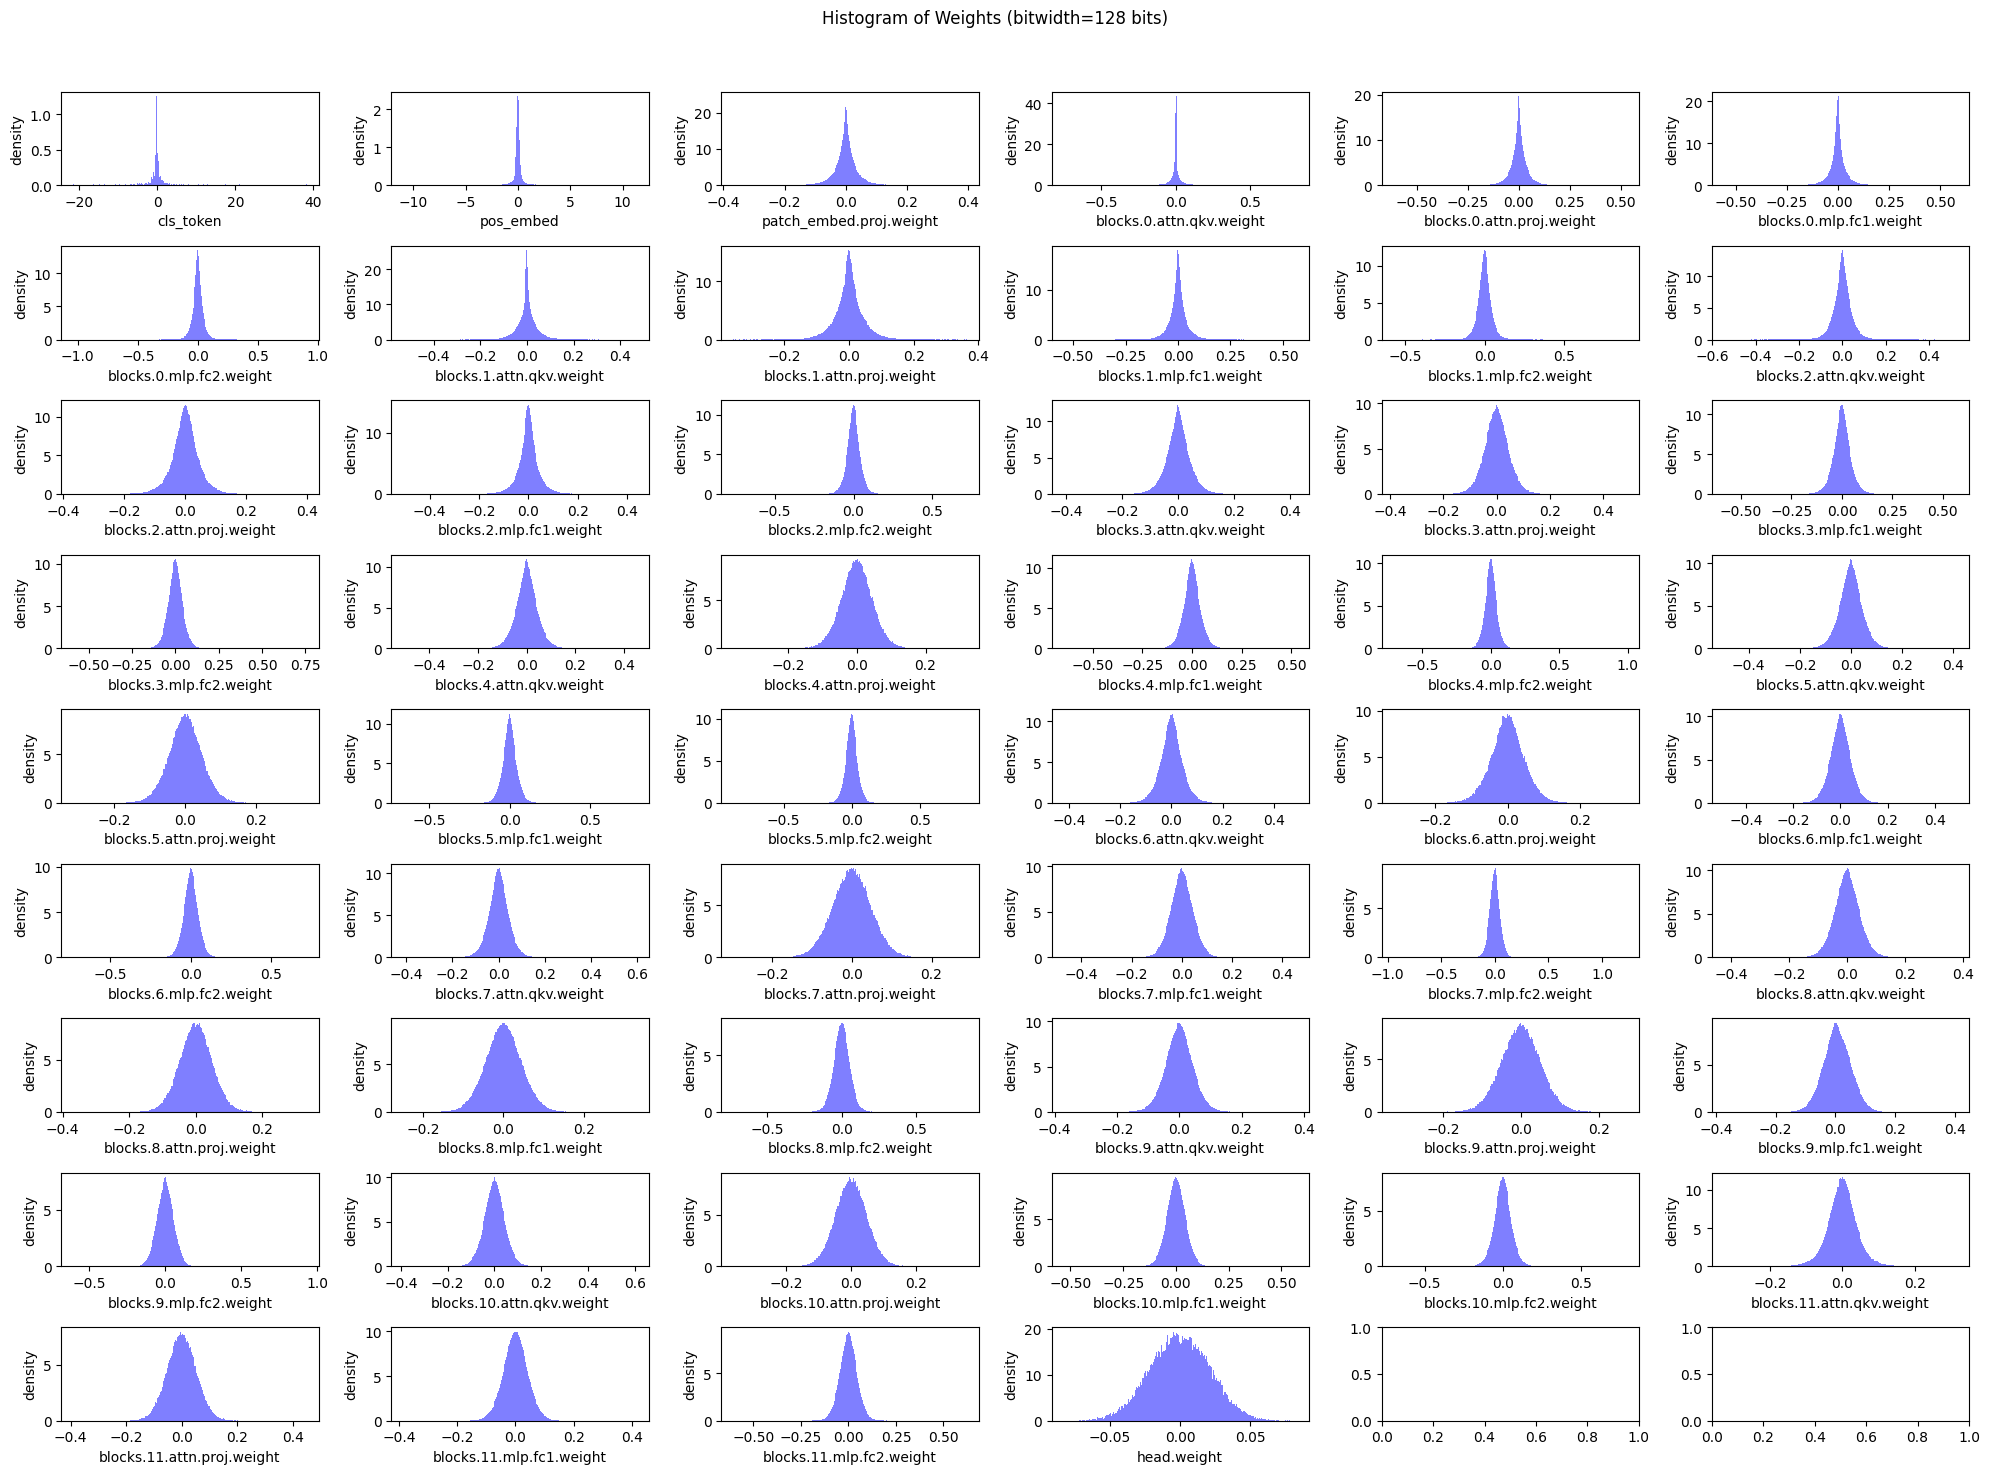

In [8]:
def plot_weight_distribution(model, bitwidth=128):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(9,6, figsize=(20, 15))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

model = torch.load("/home/edgeai/Lab 2: Quantization/model/0.9099_deit3_small_patch16_224.pth", map_location="cpu", weights_only=False)
model.cuda()
plot_weight_distribution(model)

In [16]:
device = 'cuda:0'
    
model_name = "meta-llama/Llama-3.2-1B-Instruct"   
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map=device,
)

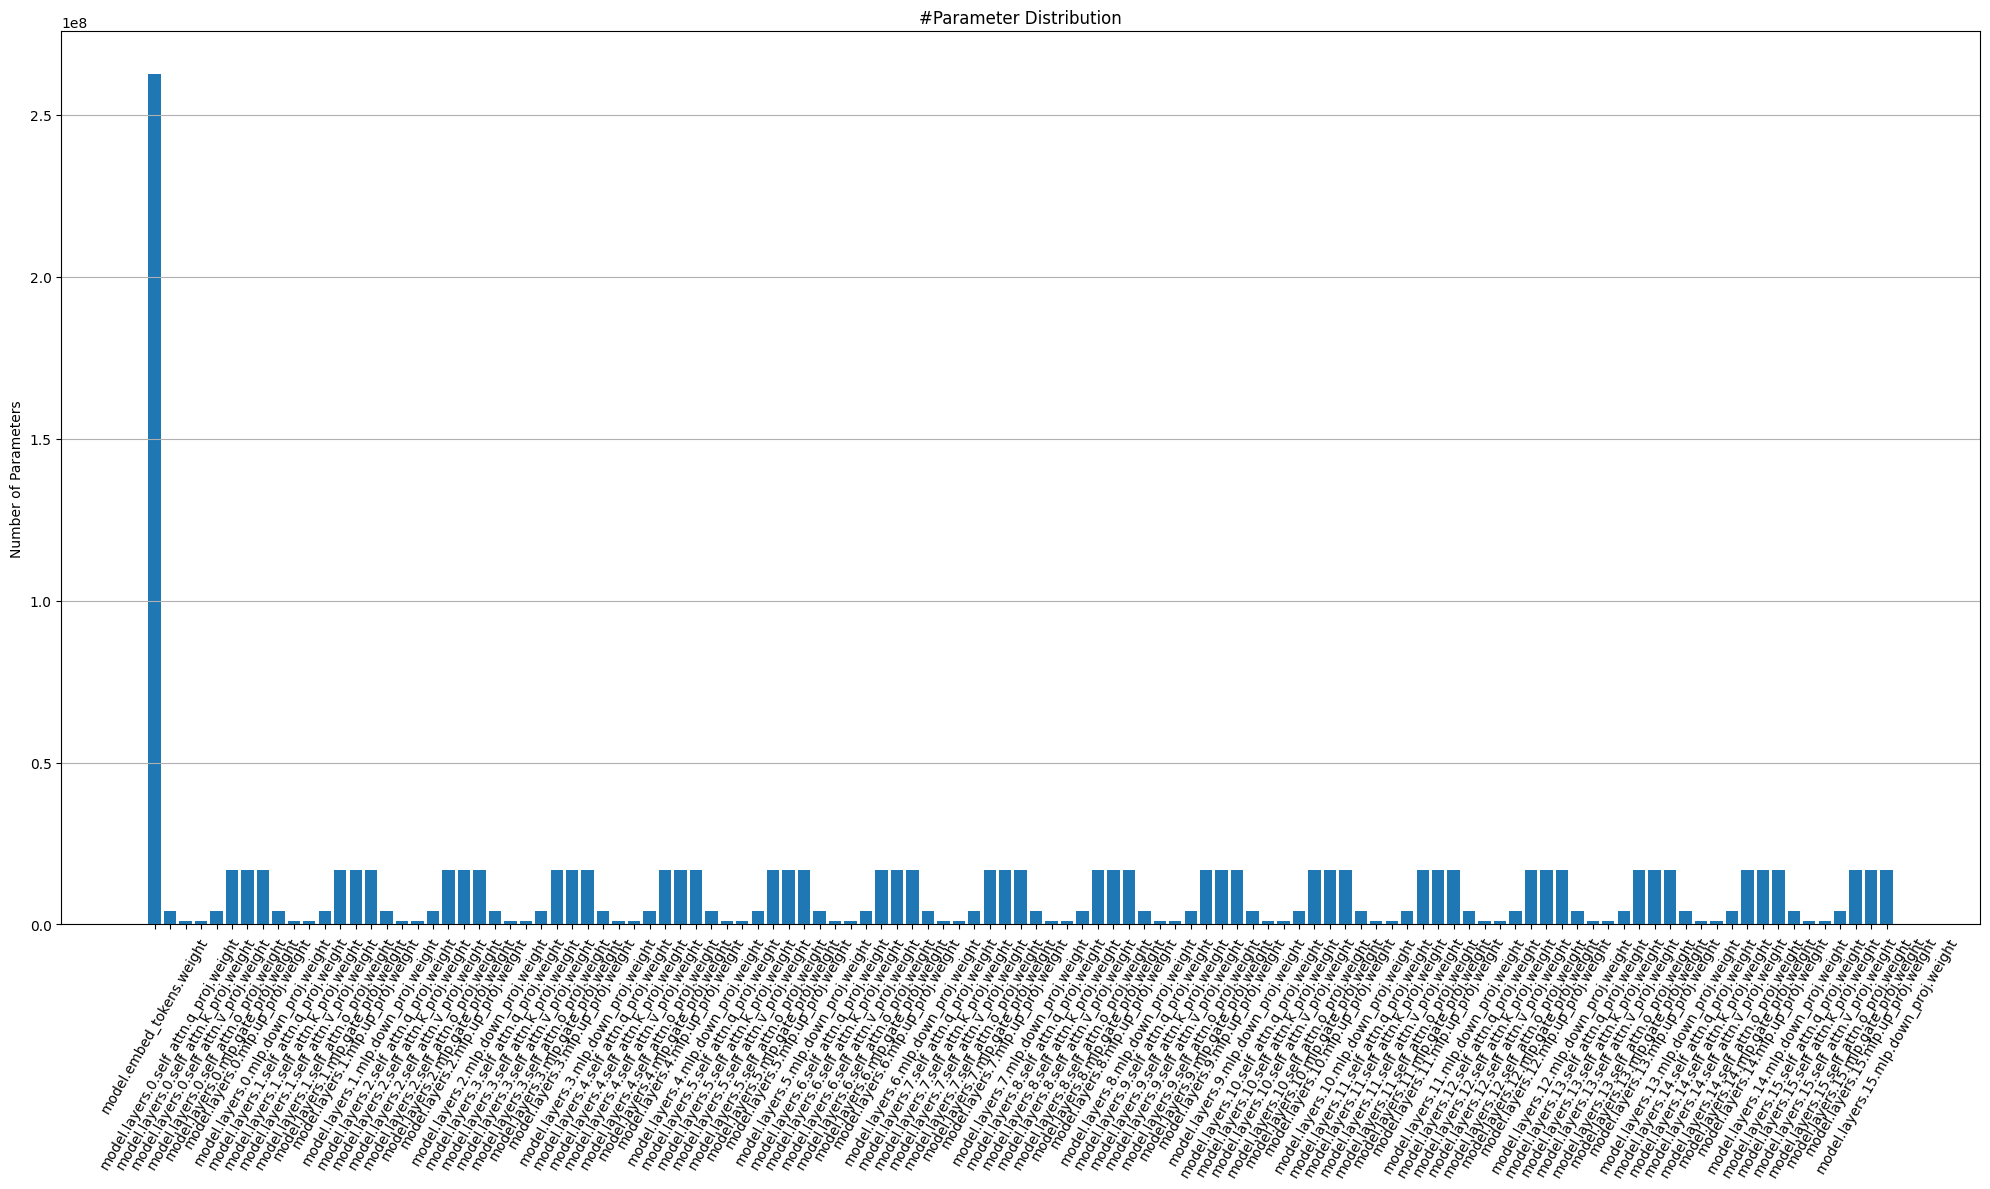

In [17]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(20, 12))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)